In [1]:
import tensorflow as tf

print(tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

2.12.0


In [2]:
!pip install -q kaggle

In [3]:
!mkdir ~/.kaggle

In [4]:
from distutils.dir_util import copy_tree
from_dir = "/kaggle/input/kaggle"
to_dir = "/root/.kaggle"
copy_tree(from_dir, to_dir)

['/root/.kaggle/kaggle.json']

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions list

ref                                                                                           deadline             category            reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
https://www.kaggle.com/competitions/asl-fingerspelling                                        2023-08-24 23:59:00  Research          $200,000        705           False  
https://www.kaggle.com/competitions/icr-identify-age-related-conditions                       2023-08-10 23:59:00  Featured           $60,000       5275           False  
https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries                      2023-10-11 23:59:00  Featured           $60,000        115           False  
https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature                      2023-07-31 23:59:00  Research           $50,000    

In [7]:
!kaggle datasets download -d grassknoted/asl-alphabet

 98%|██████████████████████████████████████▎| 1.01G/1.03G [00:07<00:00, 192MB/s]
100%|███████████████████████████████████████| 1.03G/1.03G [00:07<00:00, 154MB/s]


In [8]:
!unzip asl-alphabet.zip

Archive:  asl-alphabet.zip
  inflating: asl_alphabet_test/asl_alphabet_test/A_test.jpg  
  inflating: asl_alphabet_test/asl_alphabet_test/B_test.jpg  
  inflating: asl_alphabet_test/asl_alphabet_test/C_test.jpg  
  inflating: asl_alphabet_test/asl_alphabet_test/D_test.jpg  
  inflating: asl_alphabet_test/asl_alphabet_test/E_test.jpg  
  inflating: asl_alphabet_test/asl_alphabet_test/F_test.jpg  
  inflating: asl_alphabet_test/asl_alphabet_test/G_test.jpg  
  inflating: asl_alphabet_test/asl_alphabet_test/H_test.jpg  
  inflating: asl_alphabet_test/asl_alphabet_test/I_test.jpg  
  inflating: asl_alphabet_test/asl_alphabet_test/J_test.jpg  
  inflating: asl_alphabet_test/asl_alphabet_test/K_test.jpg  
  inflating: asl_alphabet_test/asl_alphabet_test/L_test.jpg  
  inflating: asl_alphabet_test/asl_alphabet_test/M_test.jpg  
  inflating: asl_alphabet_test/asl_alphabet_test/N_test.jpg  
  inflating: asl_alphabet_test/asl_alphabet_test/O_test.jpg  
  inflating: asl_alphabet_test/asl_alphabet

In [9]:
# Specifying the training and test directories

TRAINING_DIR = './asl_alphabet_train/asl_alphabet_train/'
TEST_DIR = './asl_alphabet_test/asl_alphabet_test/'

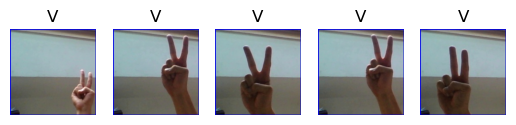

In [10]:
# Printing 5 random images from any training category or from a specified category
%matplotlib inline

import cv2
import os
import random
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

number_of_rows = 1
number_of_columns = 5

categories = os.listdir(TRAINING_DIR)

random.seed(13)

category = categories[random.randint(1, 30)]
# category = 'A'

for i in range(number_of_columns):
  subplot = plt.subplot(number_of_rows, number_of_columns, i + 1)
  subplot.axis('Off')
  subplot.set_title(category)
  image_path = os.path.join(
      TRAINING_DIR,
      str(category),
      str(category) + str(random.randint(1, 1000)) + '.jpg'
  )
  image = mpimg.imread(image_path)
  plt.imshow(image)

plt.show()

In [11]:
# Preparing ImageDataGenerator object for training the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 200
BATCH_SIZE = 64

data_generator = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True,
    brightness_range = [0.8, 1.0],
    zoom_range = [1.0, 1.2],
    validation_split = 0.1
)

train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size = (IMAGE_SIZE, IMAGE_SIZE), shuffle = True, seed = 13,
                                                     class_mode='categorical', batch_size = BATCH_SIZE, subset = "training")

validation_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size = (IMAGE_SIZE, IMAGE_SIZE), shuffle = True, seed = 13,
                                                     class_mode='categorical', batch_size = BATCH_SIZE, subset = "validation")

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [12]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O kaggle/input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

kaggle/input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5: No such file or directory


In [13]:
# Loading inception v3 network for transfer learning
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3

WEIGHTS_FILE = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

inception_v3_model = InceptionV3(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), 
    include_top = False, 
    weights = 'imagenet'
)

# Not required --> inception_v3_model.load_weights(WEIGHTS_FILE)

# Enabling the top 2 inception blocks to train
for layer in inception_v3_model.layers[:249]:
    layer.trainable = False
for layer in inception_v3_model.layers[249:]:
    layer.trainable = True
    
# Checking model summary to pick a layer (if required)
inception_v3_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 99, 99, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 99, 99, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                      

In [14]:
# Choosing the output layer to be merged with our FC layers (if required)
inception_output_layer = inception_v3_model.get_layer('mixed7')
print('Inception model output shape:', inception_output_layer.output_shape)

# Not required --> inception_output = inception_output_layer.output
inception_output = inception_v3_model.output

Inception model output shape: (None, 10, 10, 768)


In [15]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

x = layers.GlobalAveragePooling2D()(inception_output)
x = layers.Dense(1024, activation = 'relu')(x)
# Not required --> x = layers.Dropout(0.2)(x)                  
x = layers.Dense(29, activation = 'softmax')(x)           

model = Model(inception_v3_model.input, x) 

model.compile(
    optimizer = SGD(lr = 0.0001, momentum = 0.9),
    loss = 'categorical_crossentropy',
    metrics = ['acc']
)

In [16]:
# Watch the new model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 99, 99, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 99, 99, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [17]:
# Creating a callback to stop model training after reaching a threshold accuracy

LOSS_THRESHOLD = 0.2
ACCURACY_THRESHOLD = 0.95

class ModelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_loss') <= LOSS_THRESHOLD and logs.get('val_acc') >= ACCURACY_THRESHOLD:
      print("\nReached", ACCURACY_THRESHOLD * 100, "accuracy, Stopping!")
      self.model.stop_training = True

callback = ModelCallback()

In [18]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 100,
    validation_steps = 50,
    epochs = 50,
    callbacks = [callback]
)
     

Epoch 1/50
100/100 [==============================] - 129s 1s/step - loss: 1.0541 - acc: 0.7241 - val_loss: 0.9950 - val_acc: 0.7022
Epoch 2/50
100/100 [==============================] - 109s 1s/step - loss: 0.1831 - acc: 0.9436 - val_loss: 0.5675 - val_acc: 0.8269
Epoch 3/50
100/100 [==============================] - 112s 1s/step - loss: 0.1229 - acc: 0.9603 - val_loss: 0.5373 - val_acc: 0.8394
Epoch 4/50
100/100 [==============================] - 109s 1s/step - loss: 0.0734 - acc: 0.9773 - val_loss: 0.4431 - val_acc: 0.8619
Epoch 5/50
100/100 [==============================] - 109s 1s/step - loss: 0.0633 - acc: 0.9798 - val_loss: 0.5506 - val_acc: 0.8341
Epoch 6/50
100/100 [==============================] - 111s 1s/step - loss: 0.0548 - acc: 0.9827 - val_loss: 0.4760 - val_acc: 0.8694
Epoch 7/50
100/100 [==============================] - 103s 1s/step - loss: 0.0371 - acc: 0.9891 - val_loss: 0.4891 - val_acc: 0.8609
Epoch 8/50
100/100 [==============================] - 109s 1s/step - 

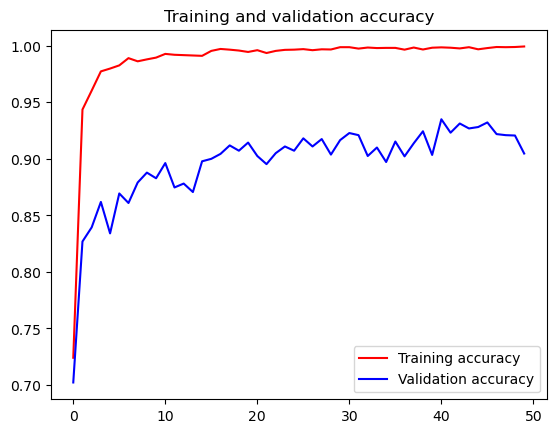

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()